<a href="https://colab.research.google.com/github/Fibbzyash/CVIP-DATA-SCIENCE/blob/main/WATER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Challenge**

The challenge is to determine how various factors influence the water availability of each presented waterbody and ensuring water availability for each time interval of the year.

In this notebook, I will one mathematical model, for prediction of Aquifer_Petrignano's Depth_to_Groundwater_P24. Similar approach can be reused for the prediction of groundwater depths of the other water bodies.

Also, I'll try to keep this notebook short and informative.

This famous quote aligns with the objective of this challenge.

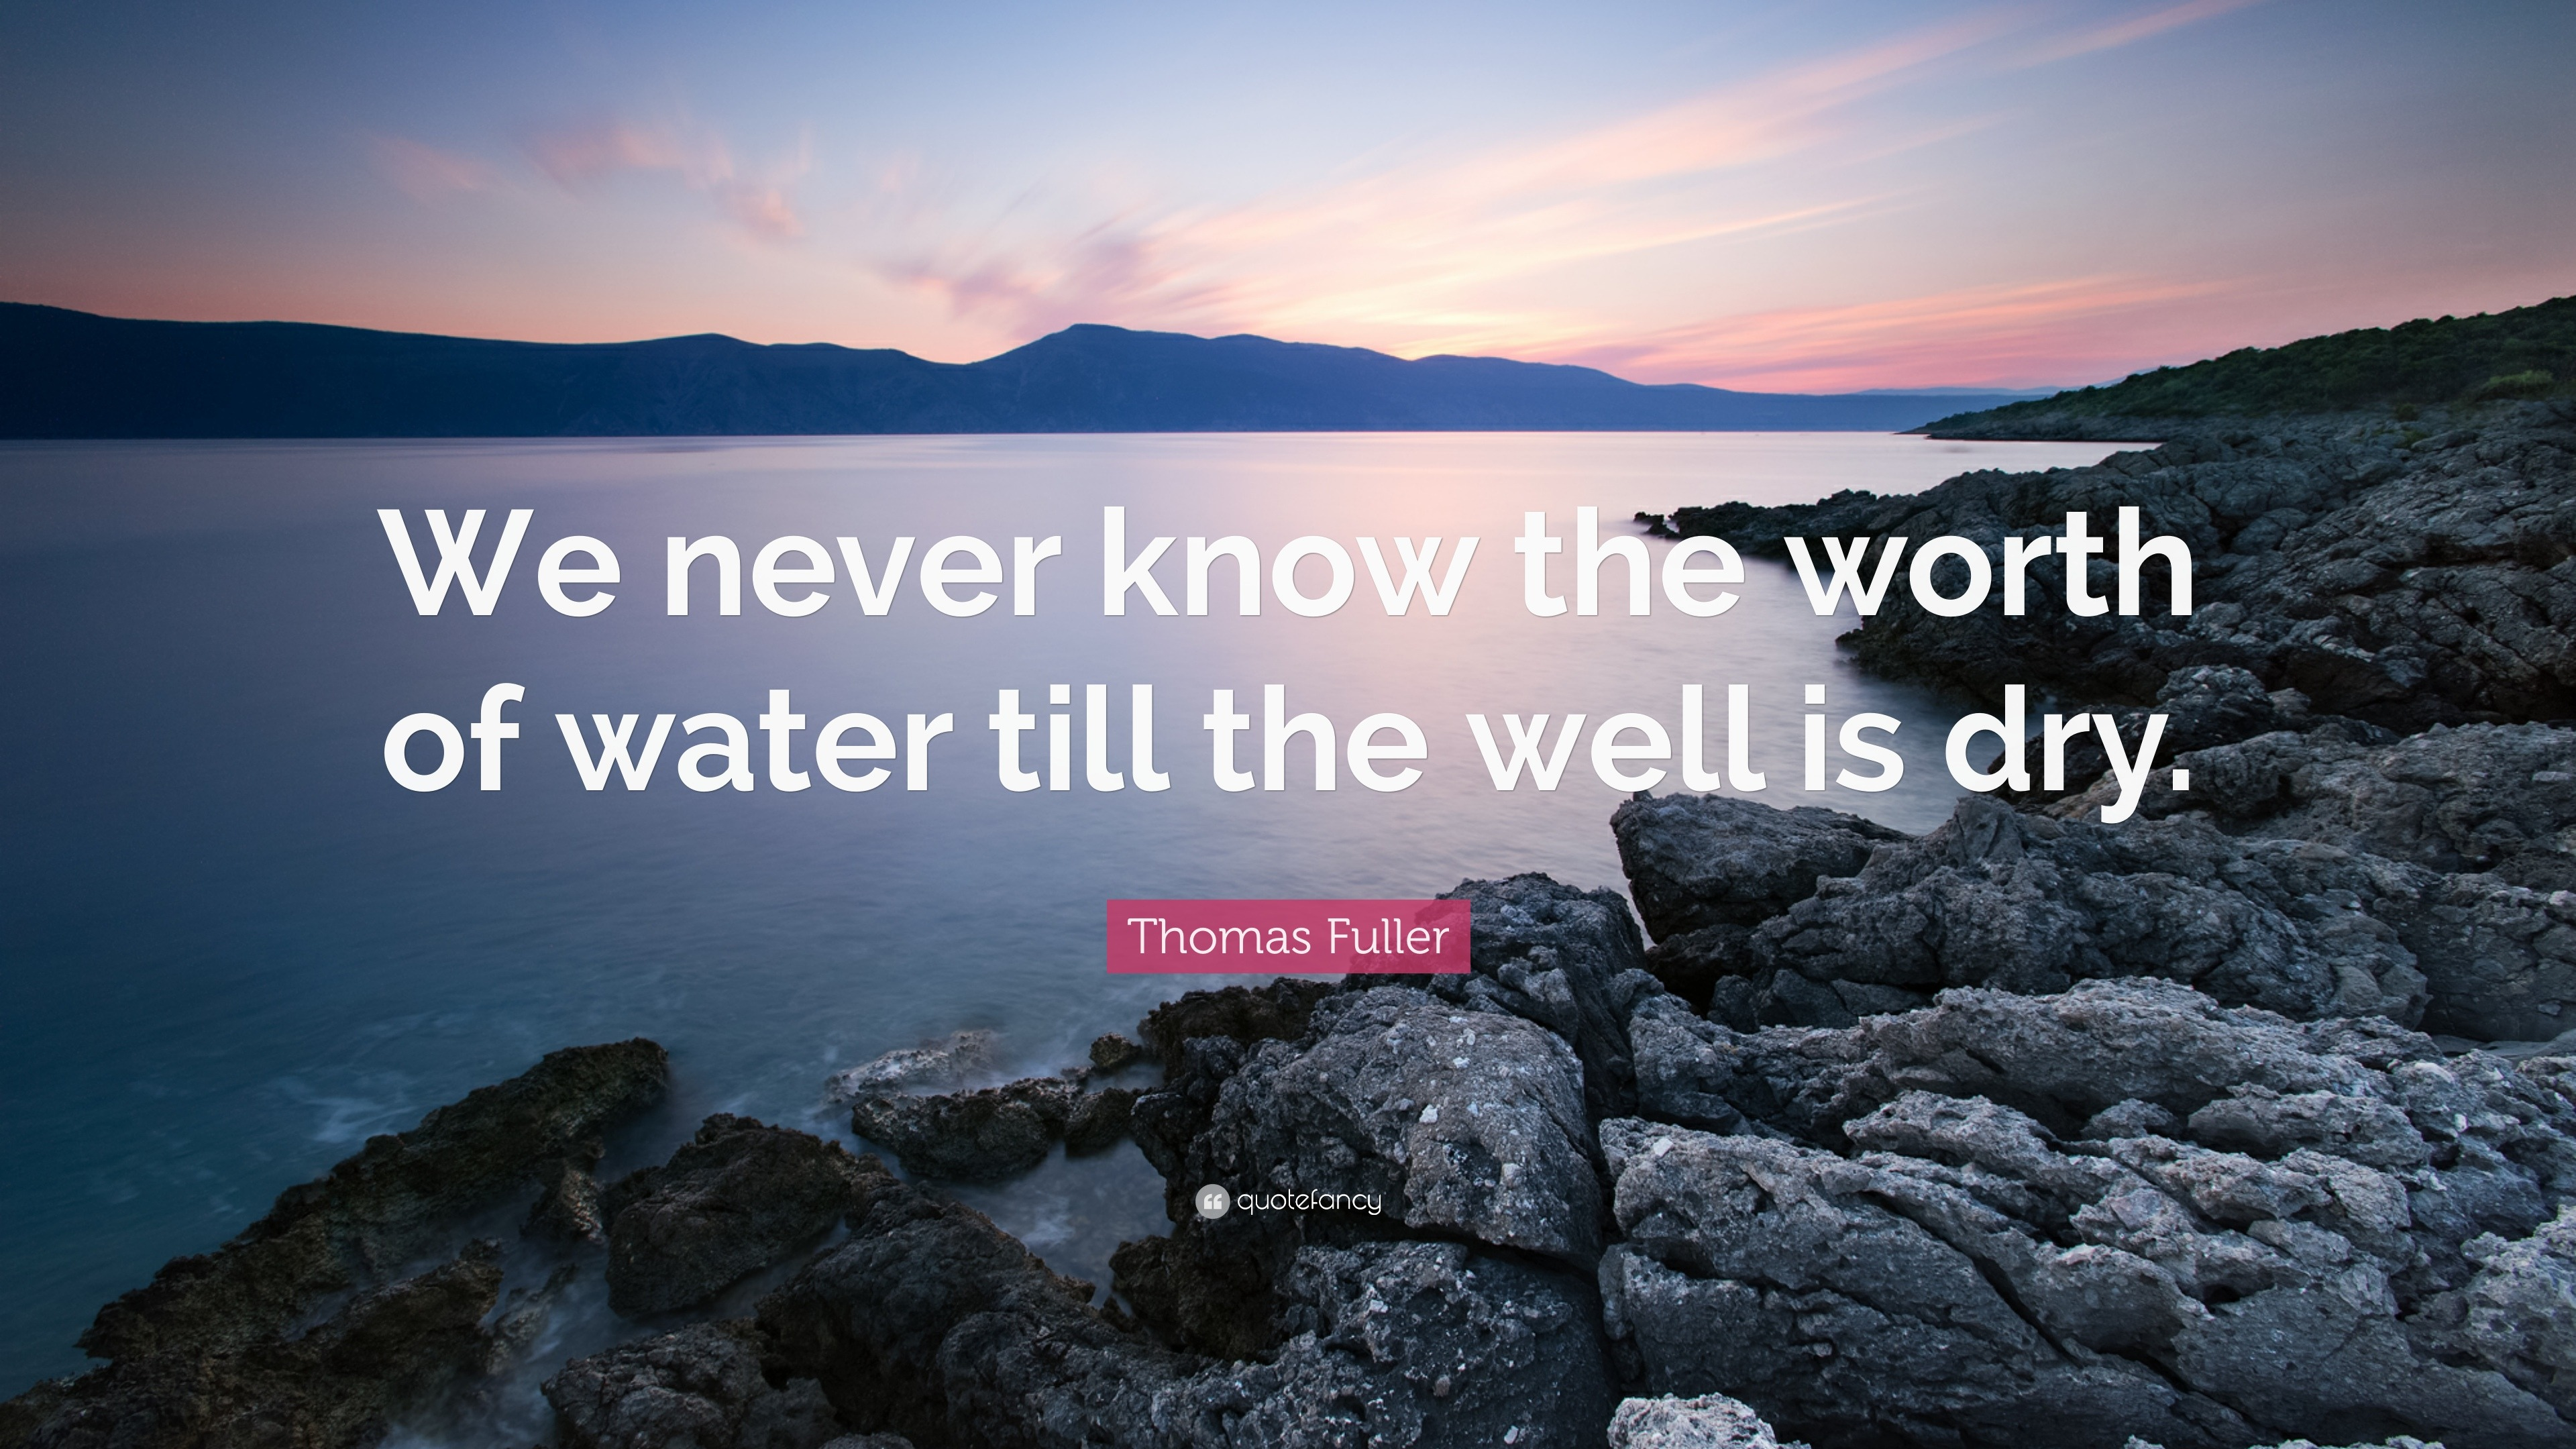

In [225]:
from IPython.display import Image, display

# Specify the path to your image file
image_path = "/content/1.jpeg"


display(Image(filename=image_path))

# START



In [125]:
pip install colorama

In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

np.random.seed(7)


In [127]:
df = pd.read_csv("/content/Aquifer_Petrignano.csv")
df.head()

Date  Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
0  14/03/2006                    NaN                    -22.48   
1  15/03/2006                    NaN                    -22.38   
2  16/03/2006                    NaN                    -22.25   
3  17/03/2006                    NaN                    -22.38   
4  18/03/2006                    NaN                    -22.60   

   Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  Temperature_Petrignano  \
0                    -22.18                       NaN                     NaN   
1                    -22.14                       NaN                     NaN   
2                    -22.04                       NaN                     NaN   
3                    -22.04                       NaN                     NaN   
4                    -22.04                       NaN                     NaN   

   Volume_C10_Petrignano  Hydrometry_Fiume_Chiascio_Petrignano  
0                    NaN                                   NaN  
1                    NaN                                   NaN  
2                    NaN                                   NaN  
3                    NaN                                   NaN  
4                    NaN                                   NaN

In [128]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [129]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()


date  rainfall  depth_to_groundwater  temperature  drainage_volume  \
0  01/01/2009       0.0                -31.14          5.2       -24530.688   
1  02/01/2009       0.0                -31.11          2.3       -28785.888   
2  03/01/2009       0.0                -31.07          4.4       -25766.208   
3  04/01/2009       0.0                -31.05          0.8       -27919.296   
4  05/01/2009       0.0                -31.01         -1.9       -29854.656   

   river_hydrometry  
0               2.4  
1               2.5  
2               2.4  
3               2.4  
4               2.3

In [130]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

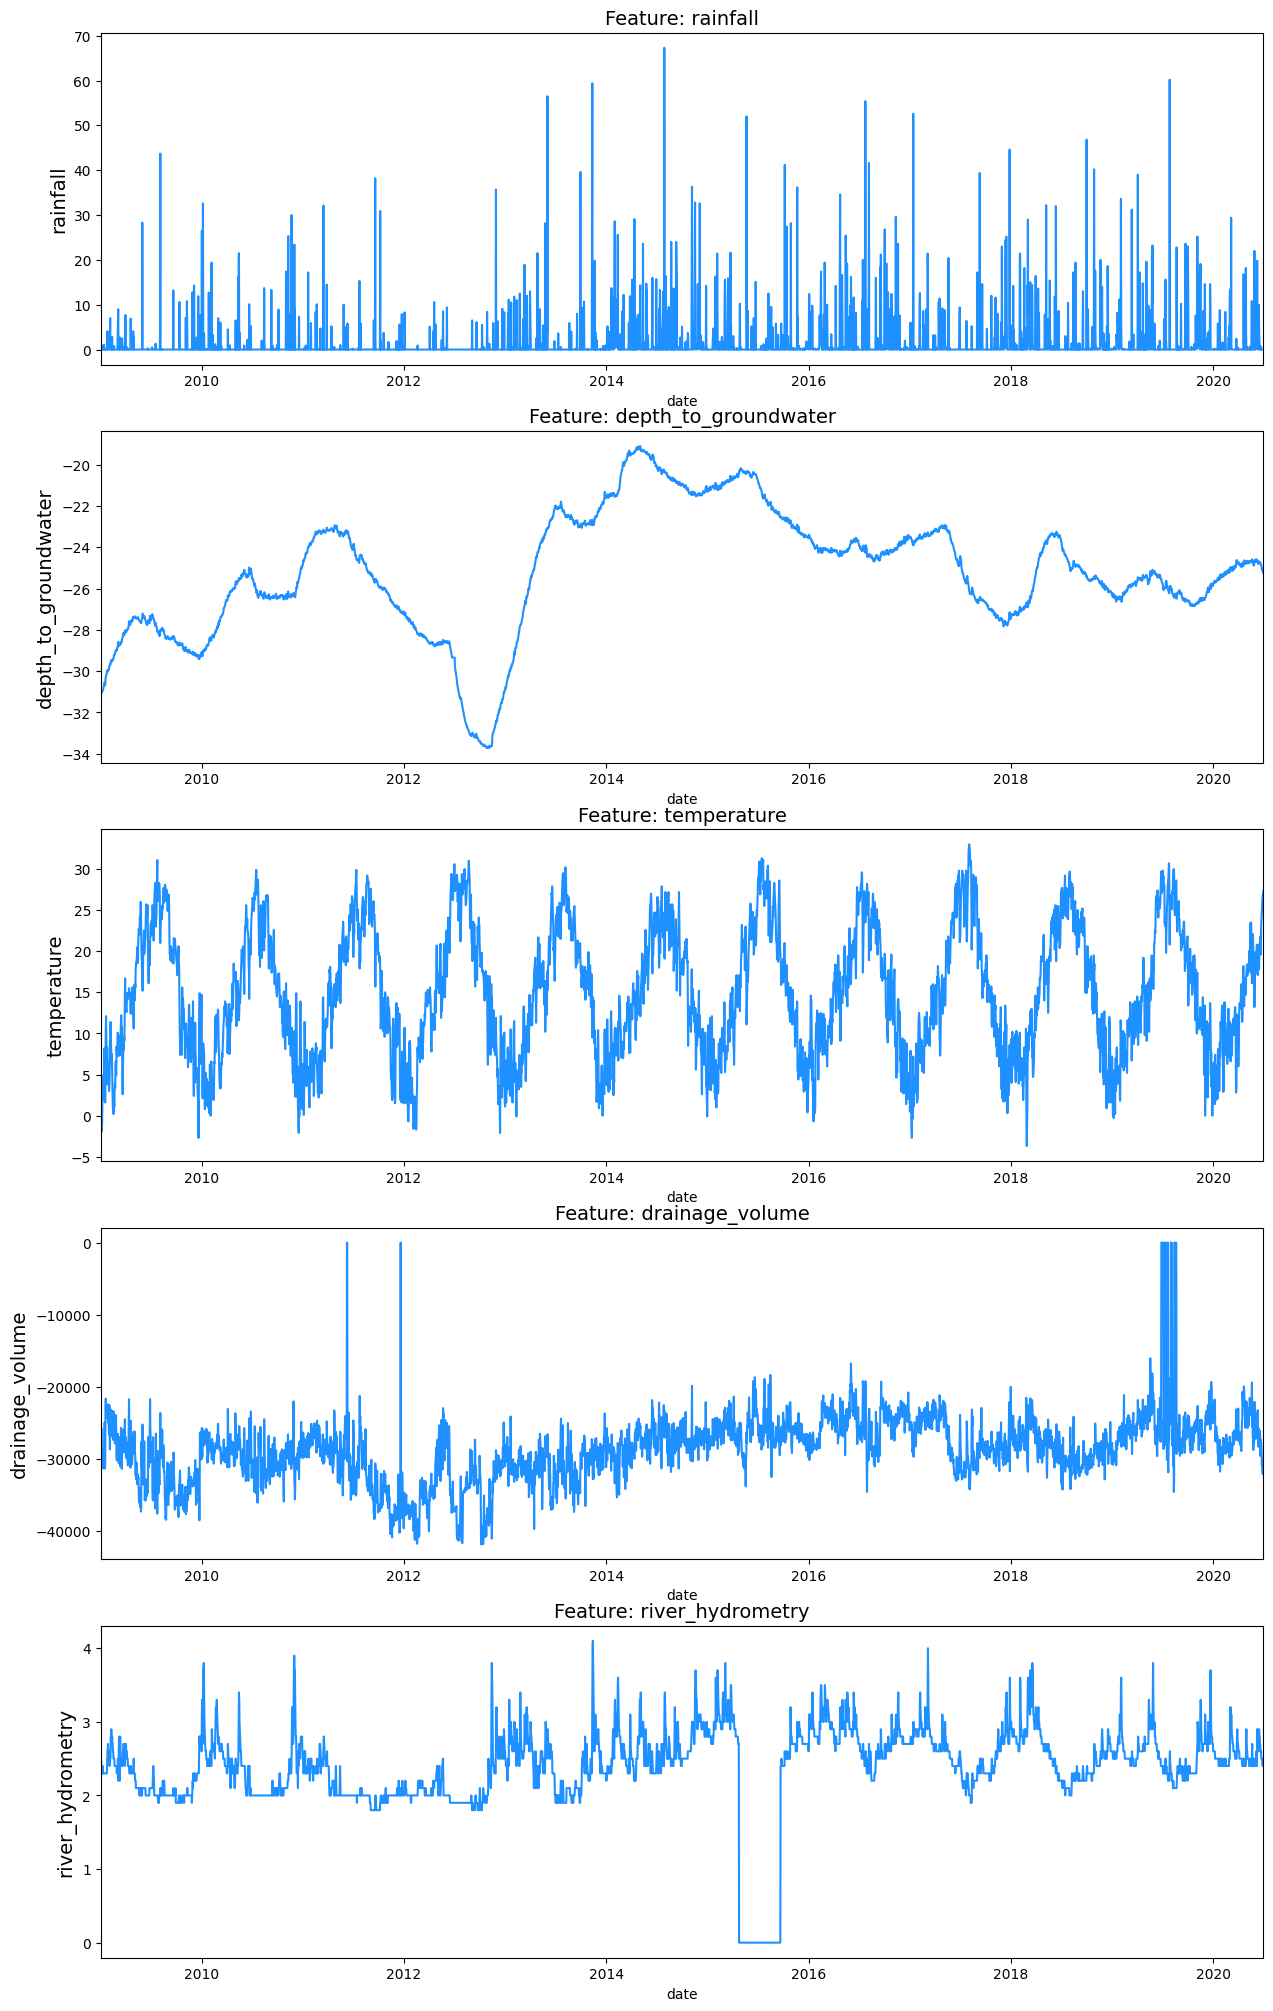

In [131]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])


# 2. Data Preprocessing ⚙️

Data preprocessing

In [132]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

date  delta
0 2009-01-01    NaT
1 2009-01-02 1 days
2 2009-01-03 1 days
3 2009-01-04 1 days
4 2009-01-05 1 days

In [133]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

handle missing values

In [134]:
df = df.drop('delta', axis=1)
df.isna().sum()


date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

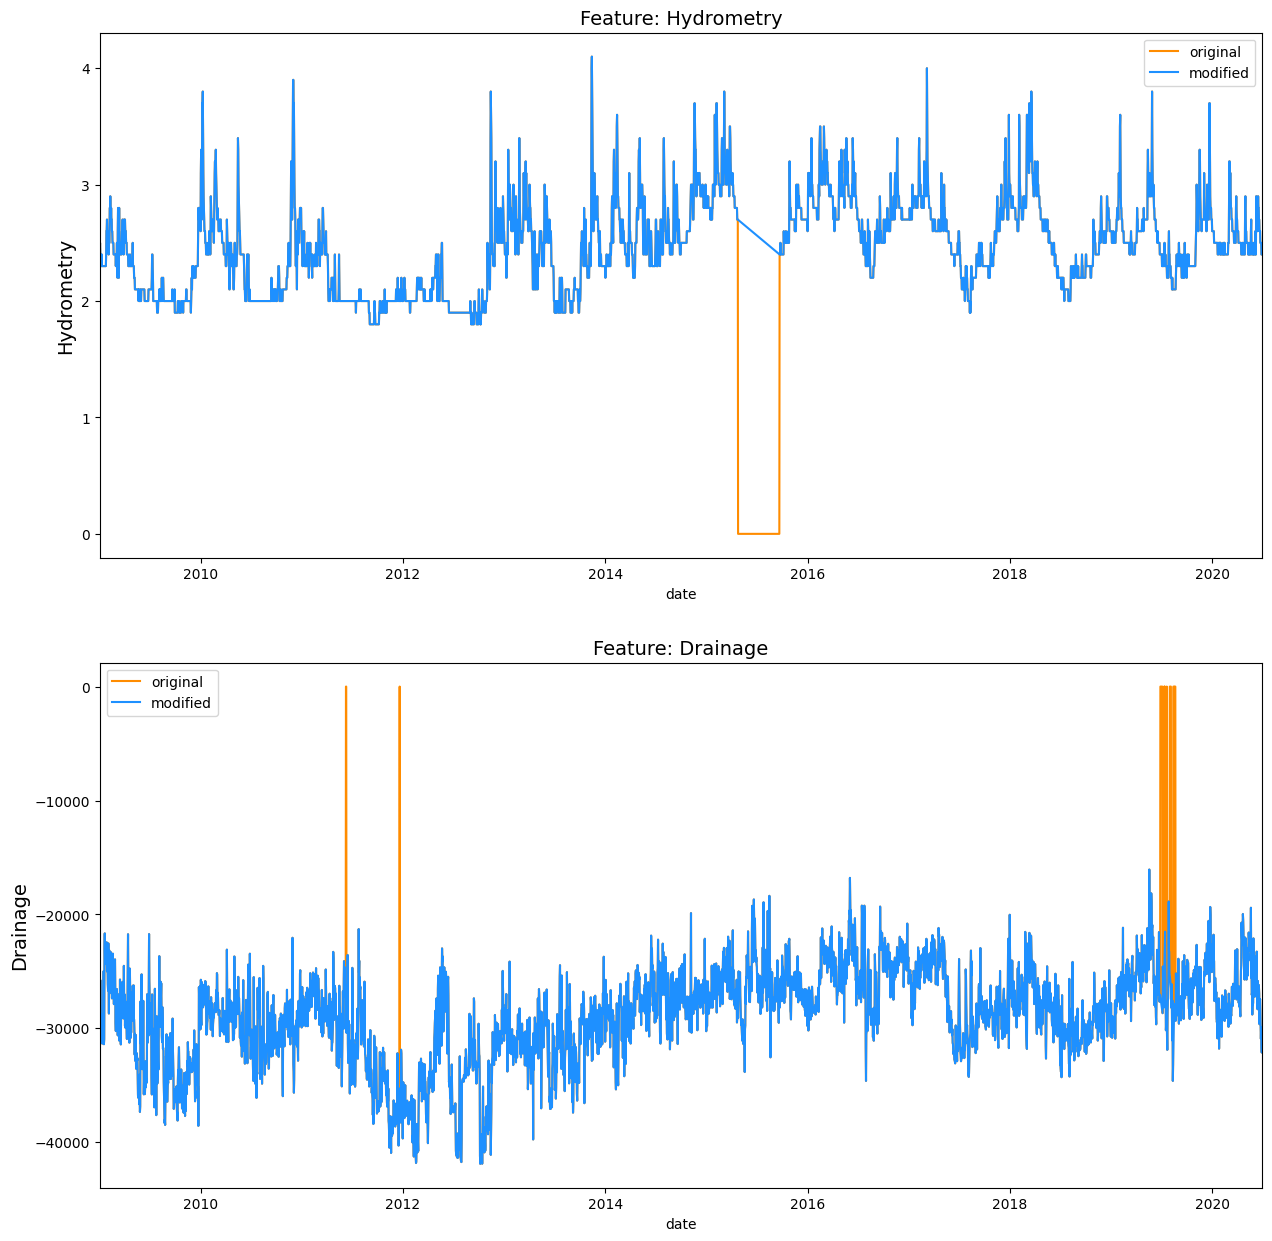

In [135]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

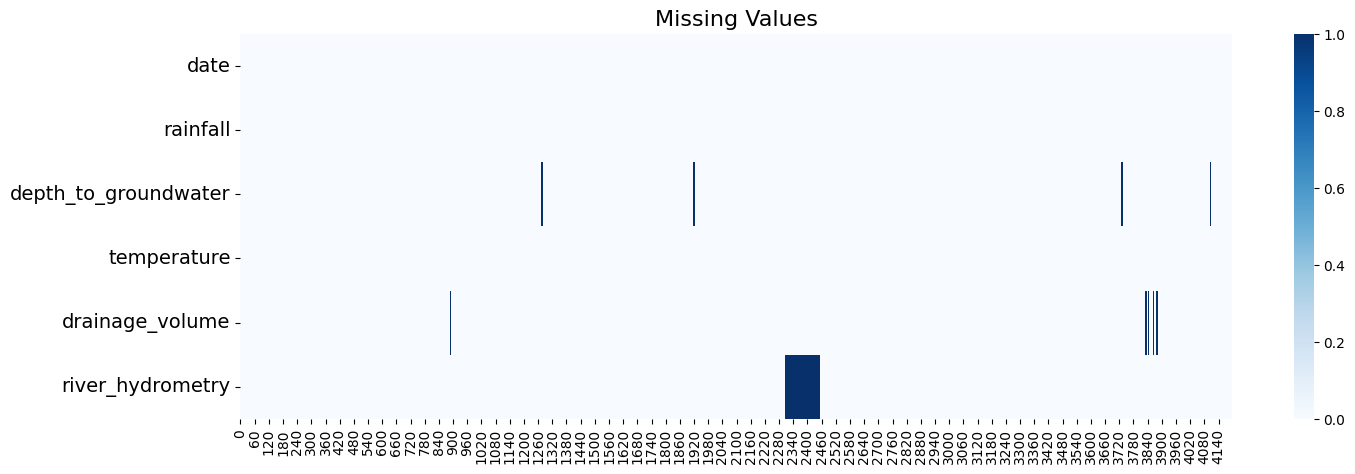

In [136]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

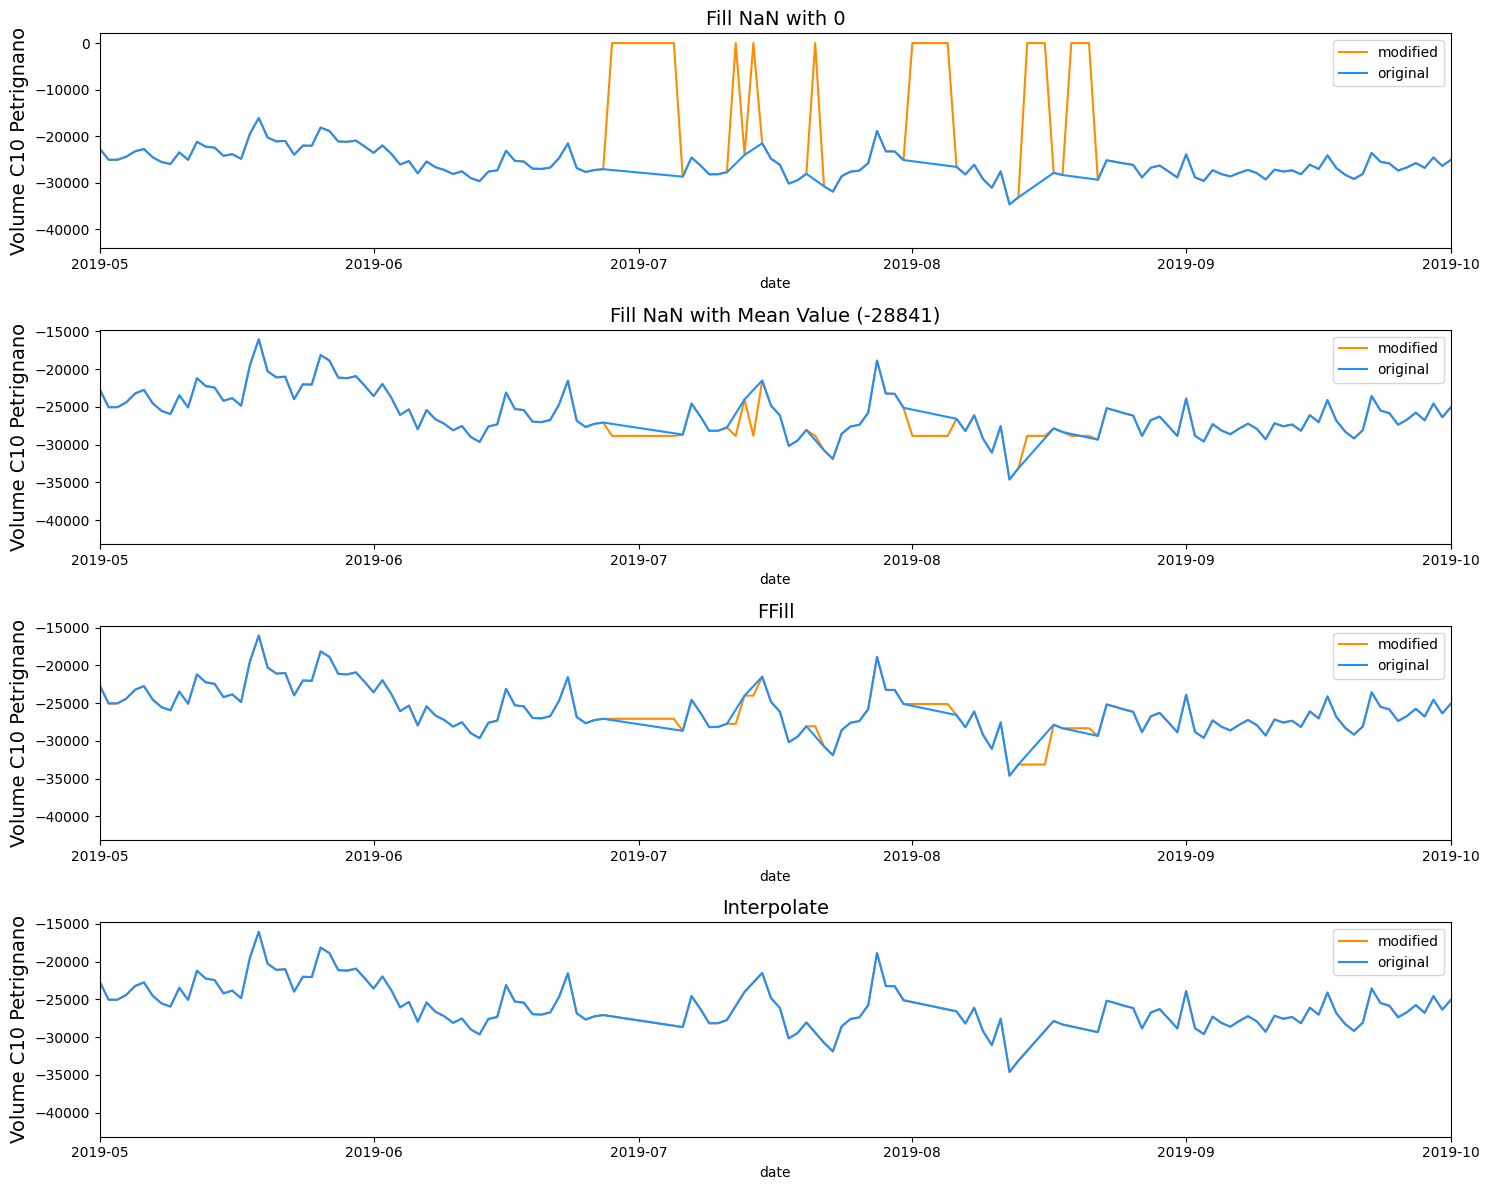

In [137]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

plt.tight_layout()
plt.show()

In [138]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date


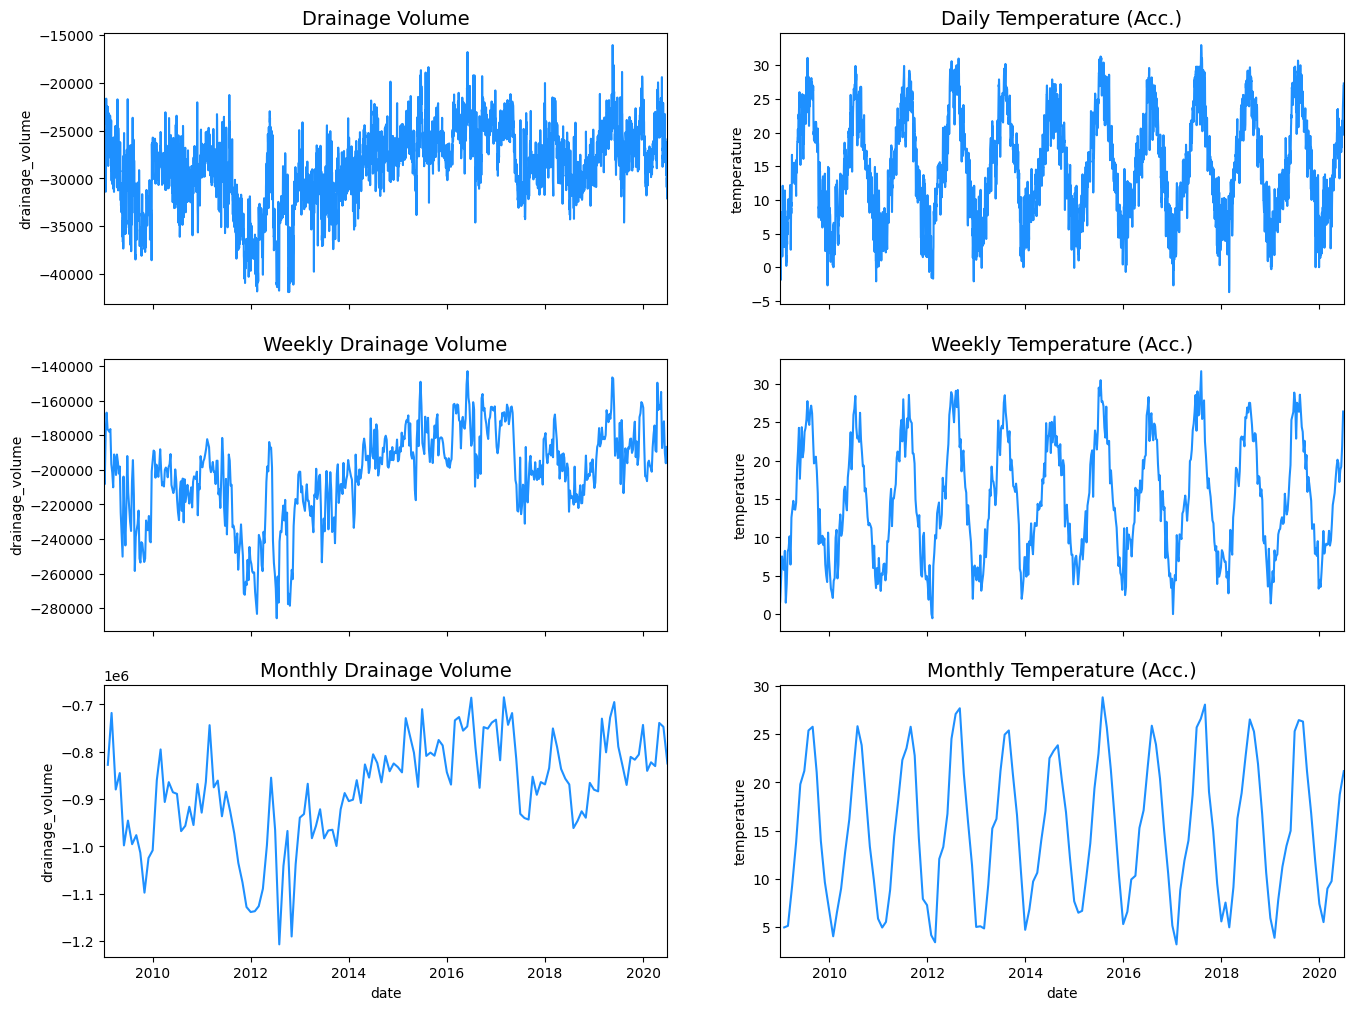

In [140]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])

ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])

ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df_temp_weekly = df[['date', 'temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_temp_weekly['date'], y=resampled_df_temp_weekly['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df_temp_monthly = df[['date', 'temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_temp_monthly['date'], y=resampled_df_temp_monthly['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()


In [141]:
# As we can see, downsample to weekly could smooth the data and hgelp with analysis
downsample = df[['date',
                 'depth_to_groundwater',
                 'temperature',
                 'drainage_volume',
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

2.3 Stationarity

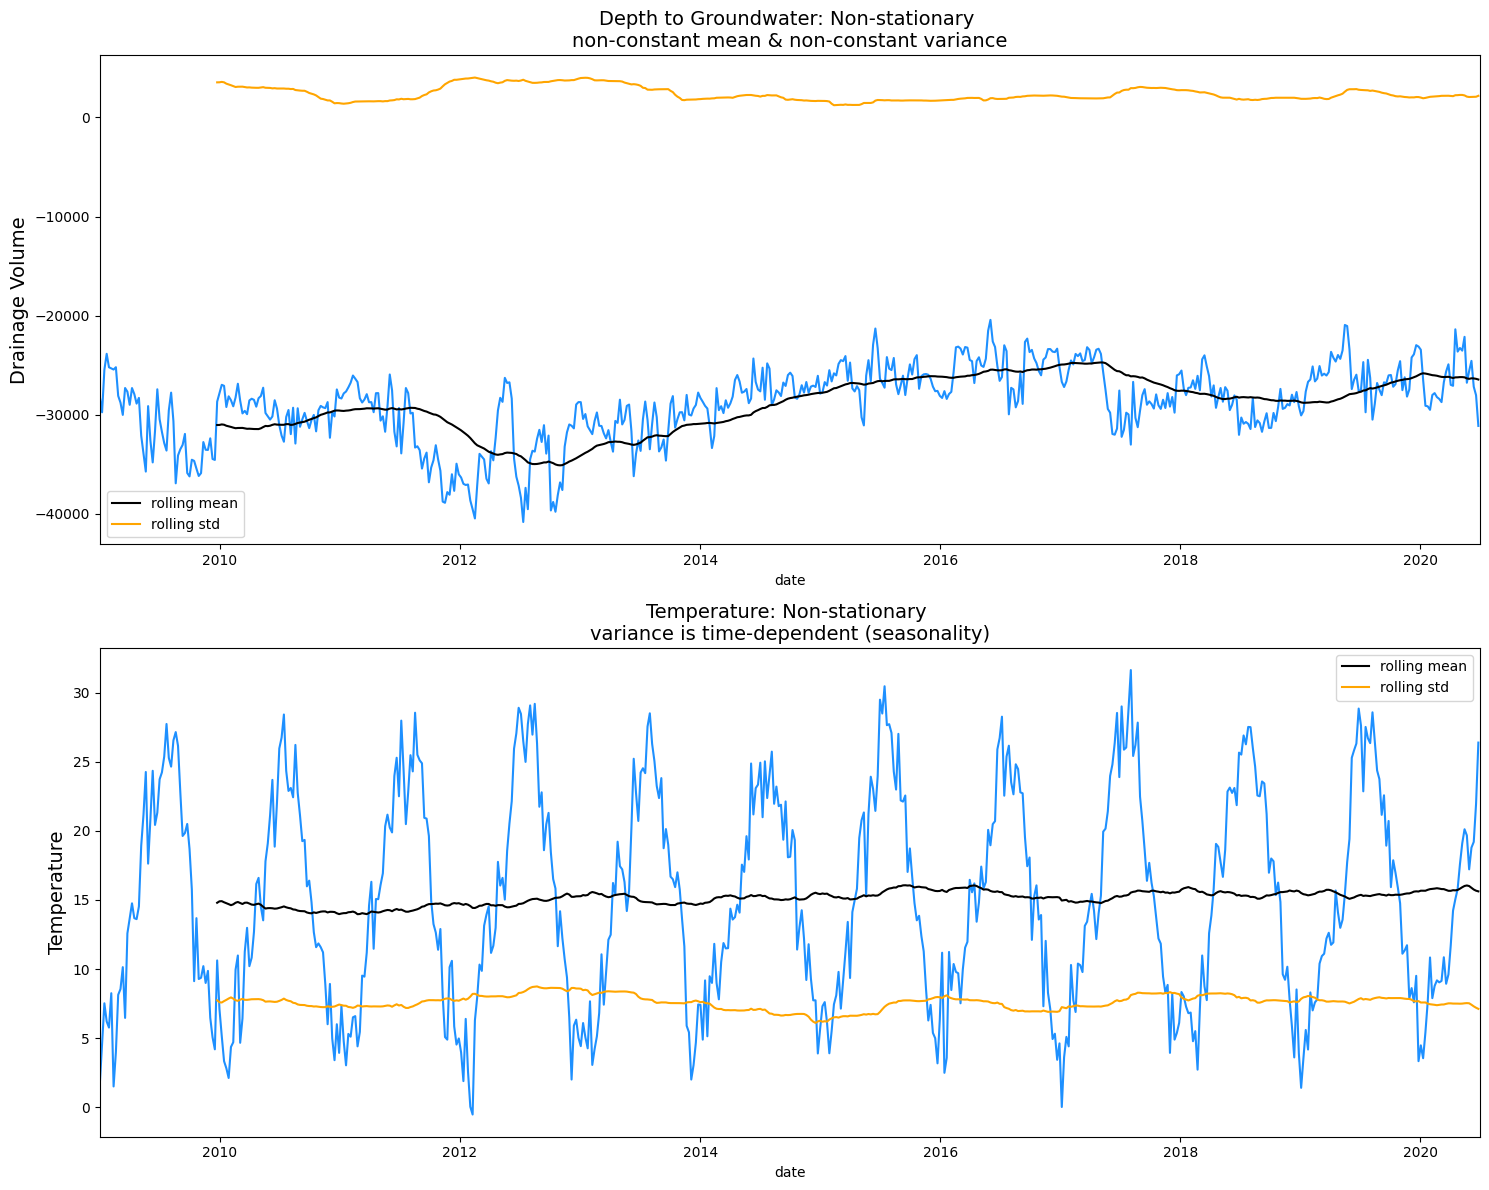

In [142]:
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [143]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.8802016493166605,
 0.047699190920208856,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

Now, we are going to check for each variable:

The p-value is less than 0.05
Check the range of the ADF statistic compared with critical_values

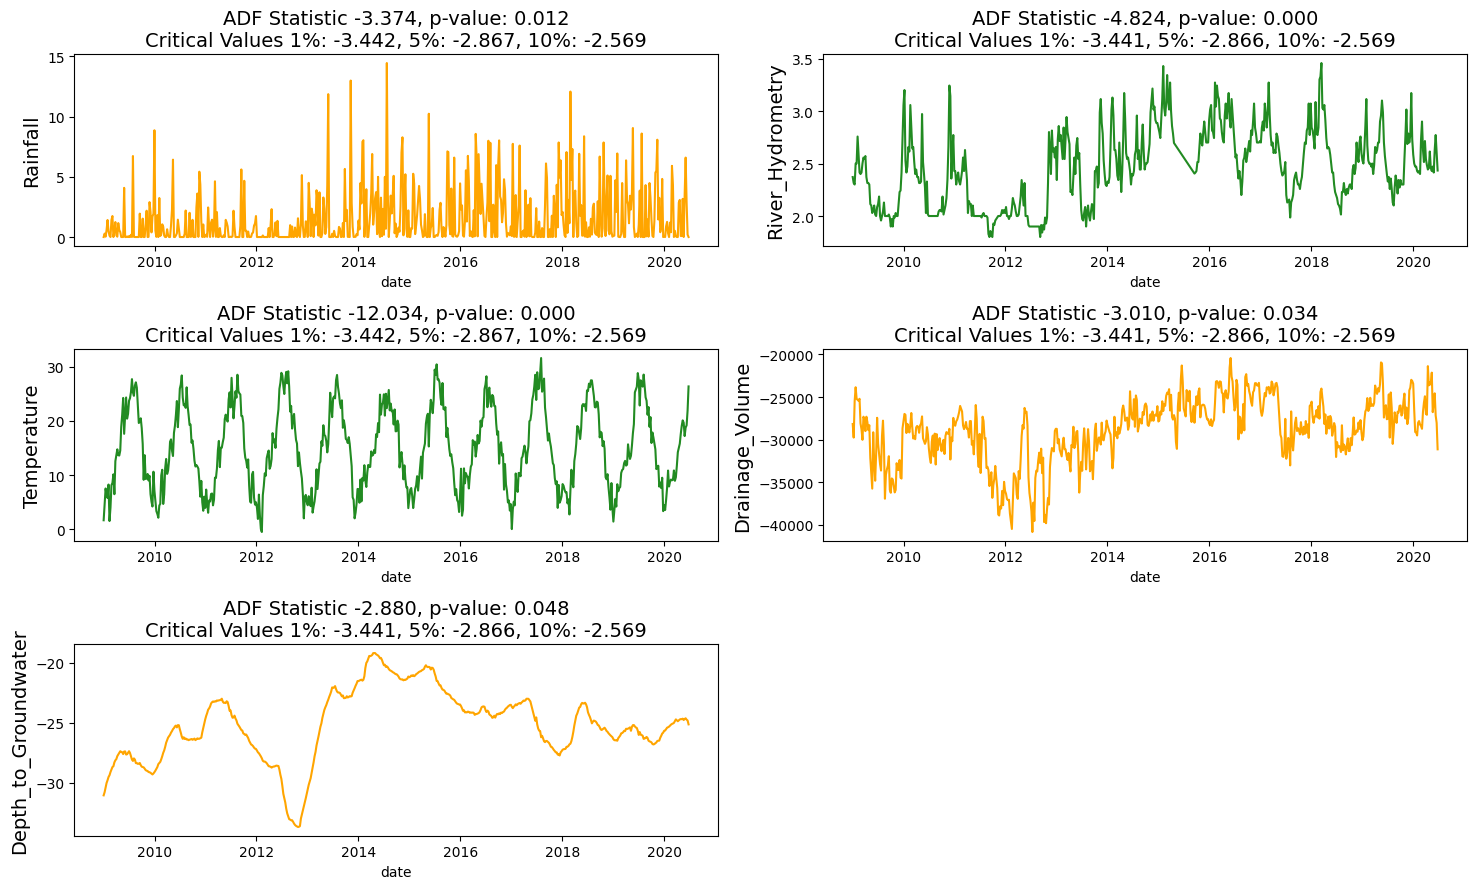

In [144]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

2.3.2 Transforming

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

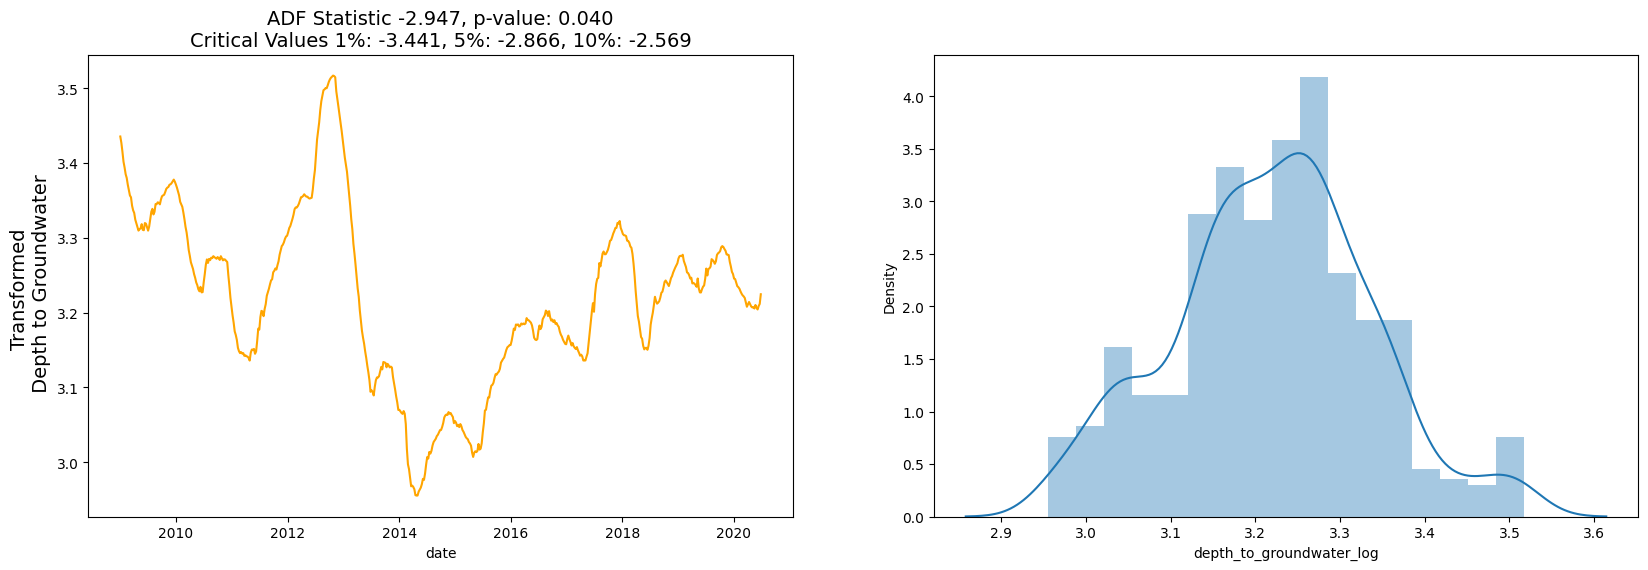

In [145]:



# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

2.3.3 Differencing

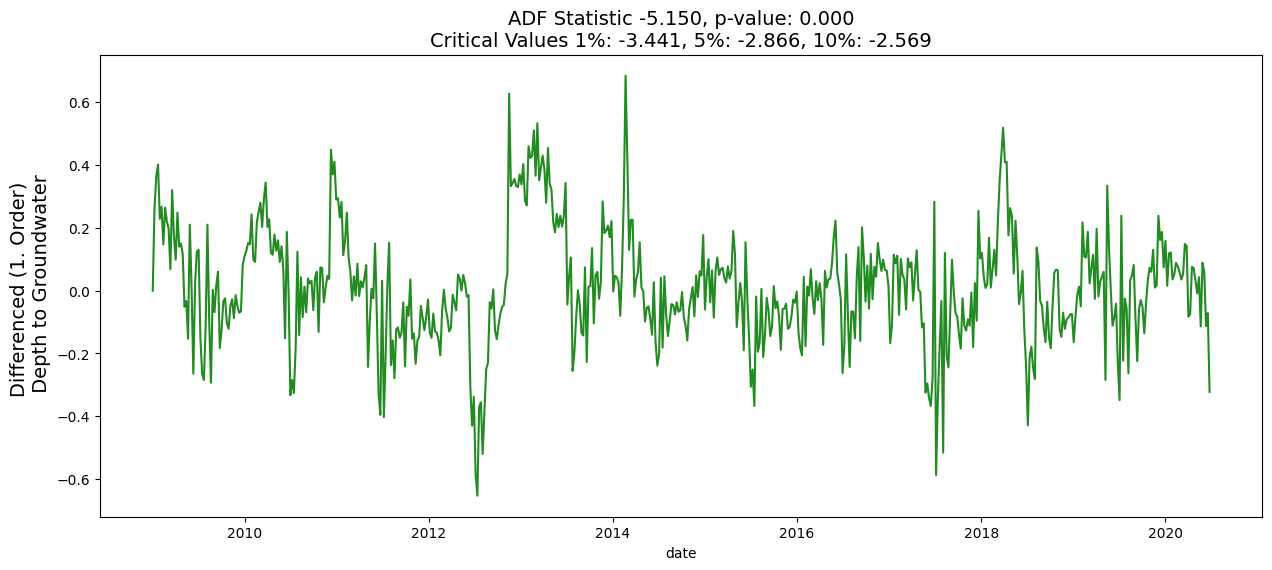

In [146]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

# 3. Feature engineering 🔧

In [147]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

date  year  month  day  day_of_year  week_of_year  quarter  season
0 2009-01-01  2009      1    1            1             1        1       1
1 2009-01-08  2009      1    8            8             2        1       1
2 2009-01-15  2009      1   15           15             3        1       1
3 2009-01-22  2009      1   22           22             4        1       1
4 2009-01-29  2009      1   29           29             5        1       1

3.1 Encoding Cyclical Features

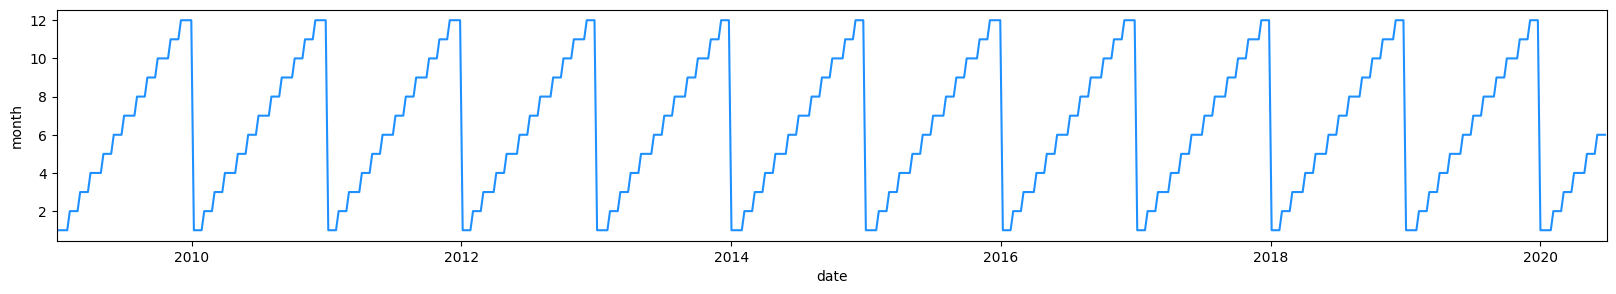

In [148]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()


In [149]:
url = 'https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide?cellIds=49&kernelSessionId=55927590'
url

'https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide?cellIds=49&kernelSessionId=55927590'

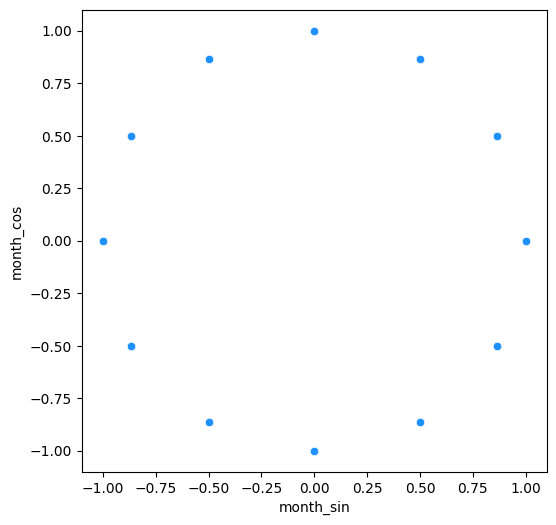

In [150]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

3.2 TimeSeries Decomposition

In [151]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume',
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

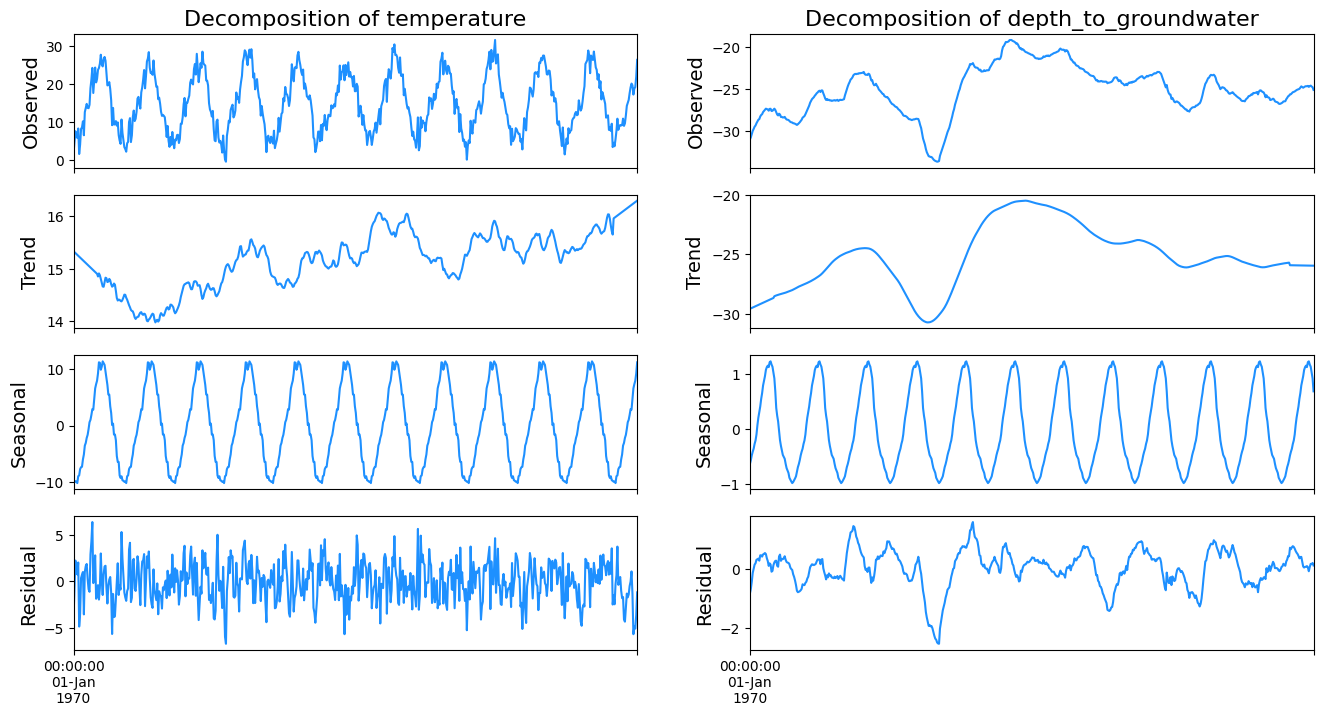

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your DataFrame has a datetime index
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16, 8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0, i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0, i], legend=False, color='dodgerblue')
    ax[0, i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1, i], legend=False, color='dodgerblue')
    ax[1, i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2, i], legend=False, color='dodgerblue')
    ax[2, i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3, i], legend=False, color='dodgerblue')
    ax[3, i].set_ylabel('Residual', fontsize=14)

plt.show()


In [153]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

# 4. Exploratory Data Analysis 📊

**Lag**

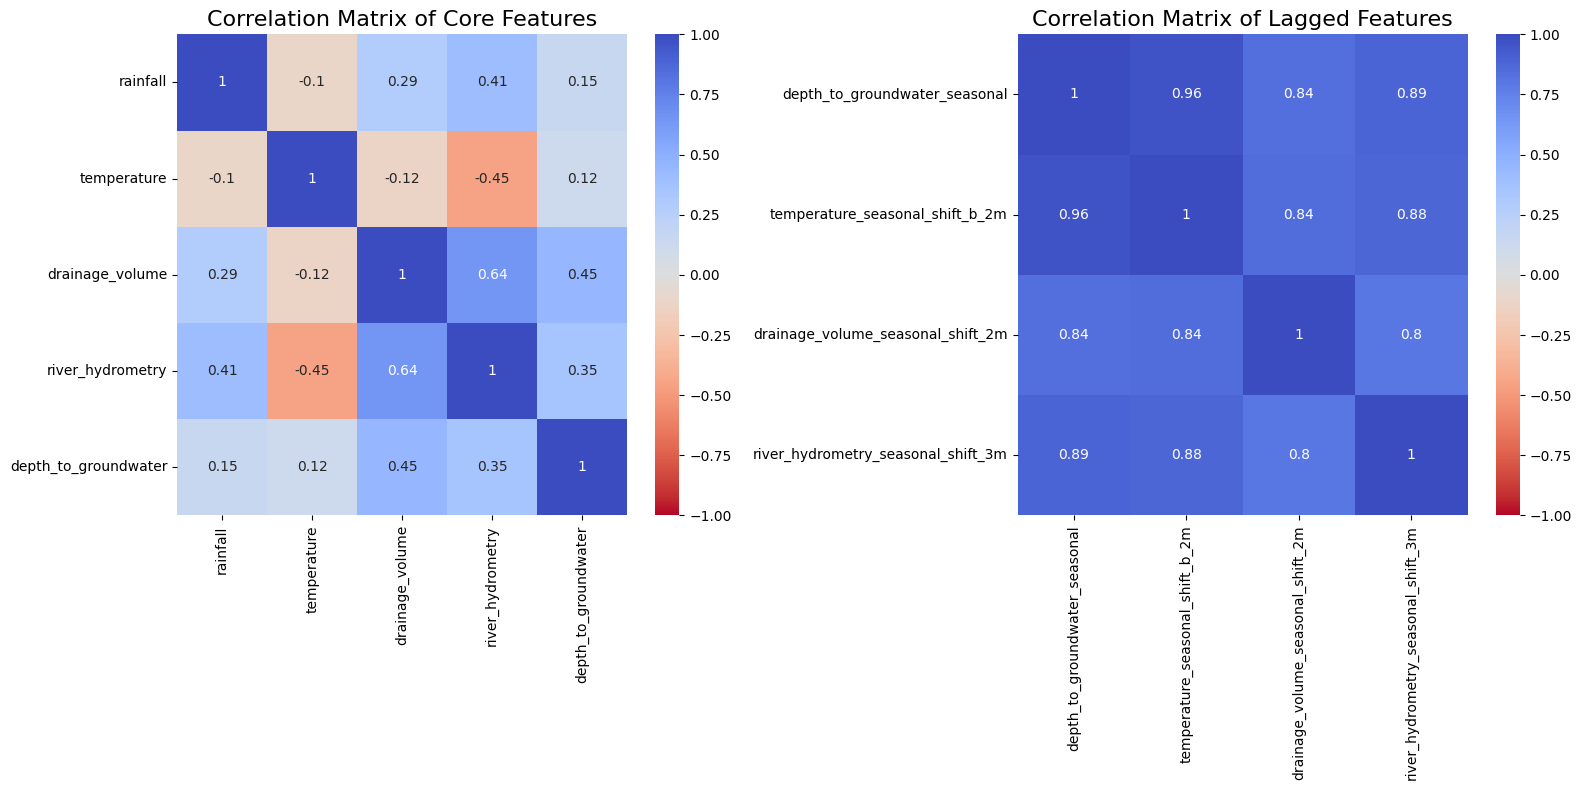

In [154]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m',
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

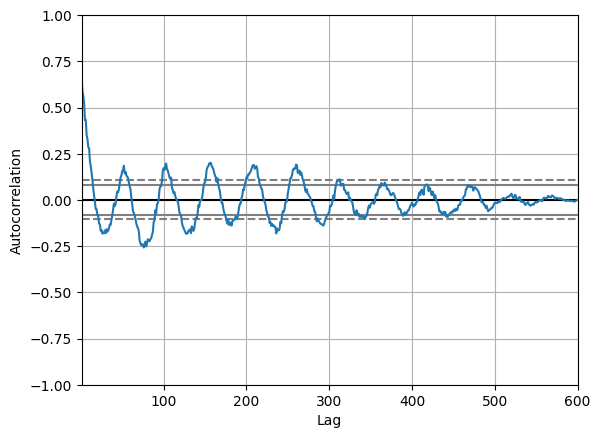

In [155]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

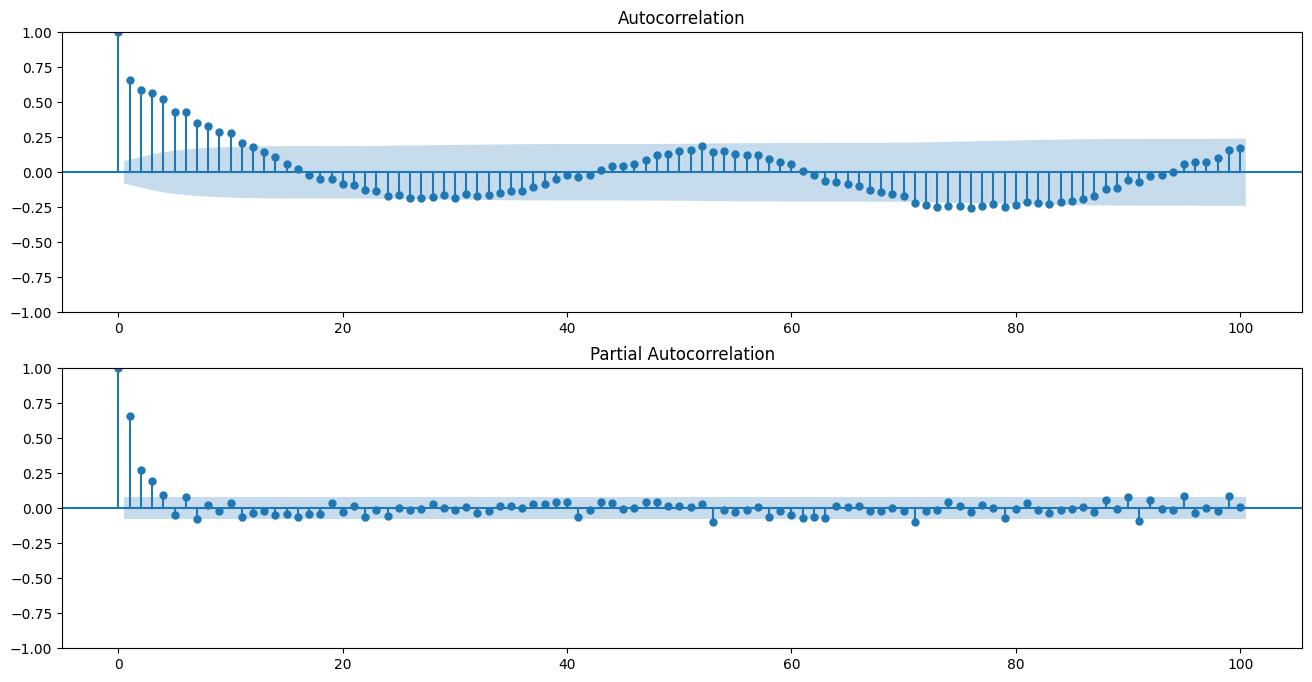

In [156]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

# Modelling

In [159]:



from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)


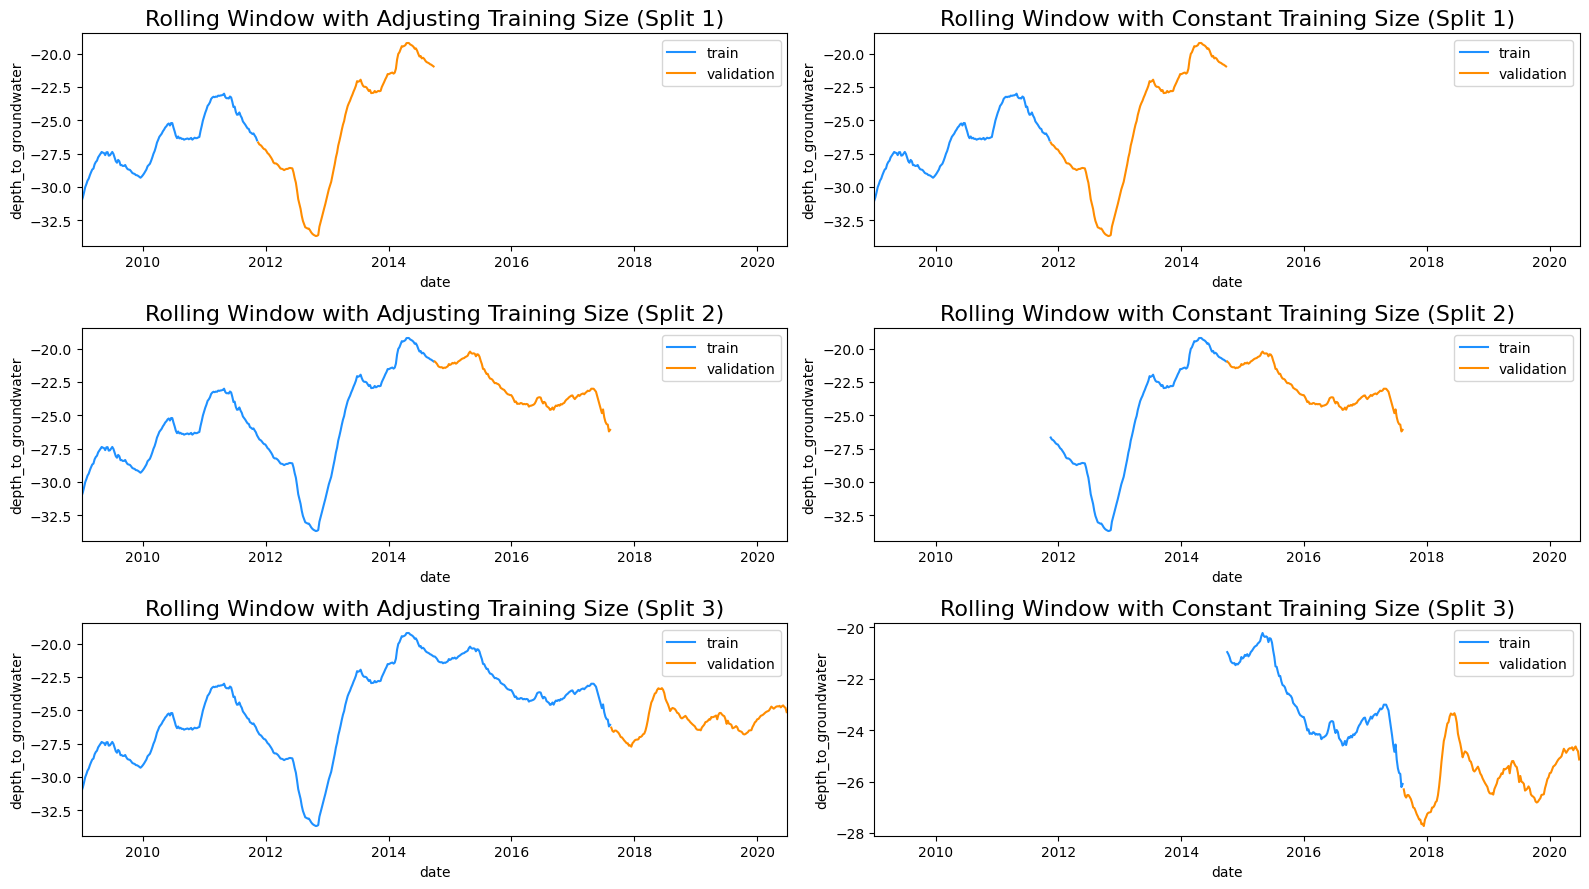

In [160]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i,0],
        color='dodgerblue',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        ax=ax[i,1],
        color='dodgerblue',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

# 5.1 Models for Univariate Time Series



In [161]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


# Arima

In [193]:
pip install Statsmodels

In [211]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from colorama import Fore

# Assuming you have properly split your data into X_train, X_valid, y_train, y_valid

# Fit model
model = ARIMA(y_train, order=(1, 1, 1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(steps=len(y_valid))

# Calculate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))


RMSE: 1.402615843711107


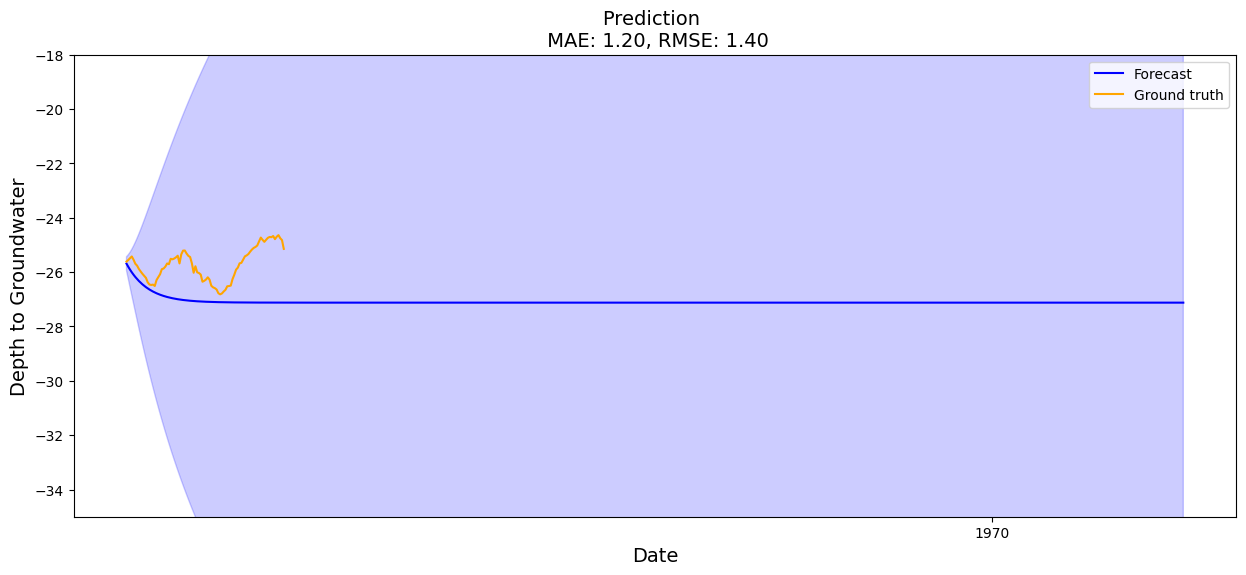

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already fitted the ARIMA model and obtained model_fit

# Get forecast object
forecast = model_fit.get_forecast(steps=599)  # Adjust the number of steps as needed

# Plot the forecast
f, ax = plt.subplots(1, figsize=(15, 6))

forecast_ci = forecast.conf_int()

# Plot the forecast
ax.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='blue')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='blue', alpha=0.2)

# Assuming x_valid is a DataFrame with datetime index
# Assuming y_valid is a DataFrame or Series with datetime index
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')  # Adjust color as needed

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(-35, -18)
plt.legend()
plt.show()


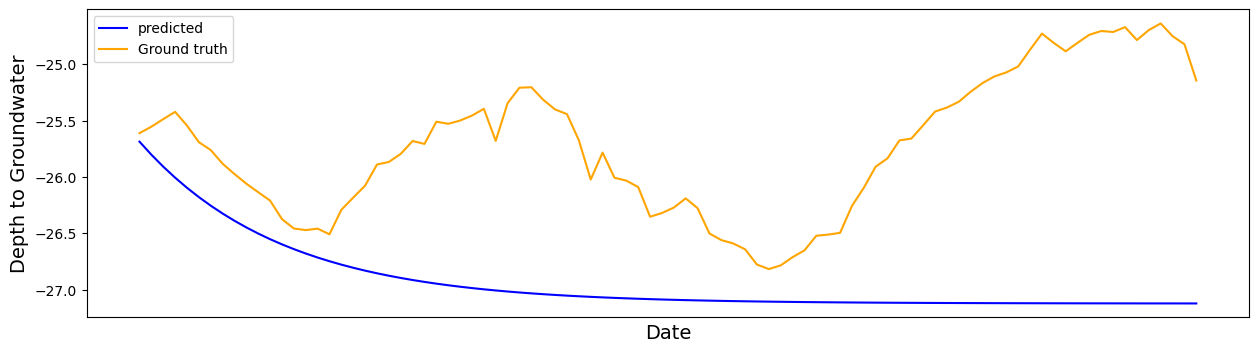

In [213]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# 5.1.3 Auto-ARIMA

In [215]:
!pip install pmdarima

In [216]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=2.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=2.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=5.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=5.79 sec
 ARIMA(1,1,2)(0,0,0)[0]          

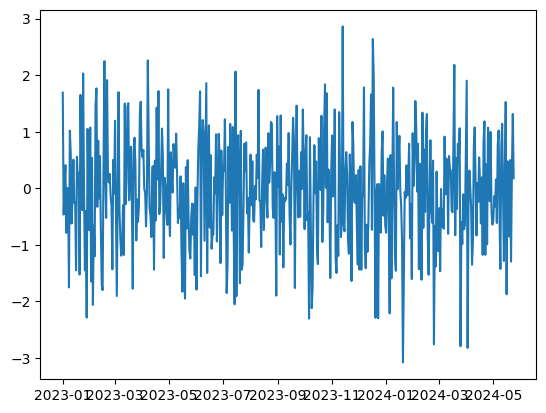

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_valid is a DataFrame with datetime index
# Assuming y_valid is a DataFrame or Series with datetime index

# Generate some example data
x_valid = pd.DataFrame(index=pd.date_range(start='2023-01-01', periods=510, freq='D'))
y_valid = pd.Series(np.random.randn(510), index=x_valid.index)

# Your plotting code
plt.plot(x_valid.index, y_valid, label='Ground truth')
plt.show()


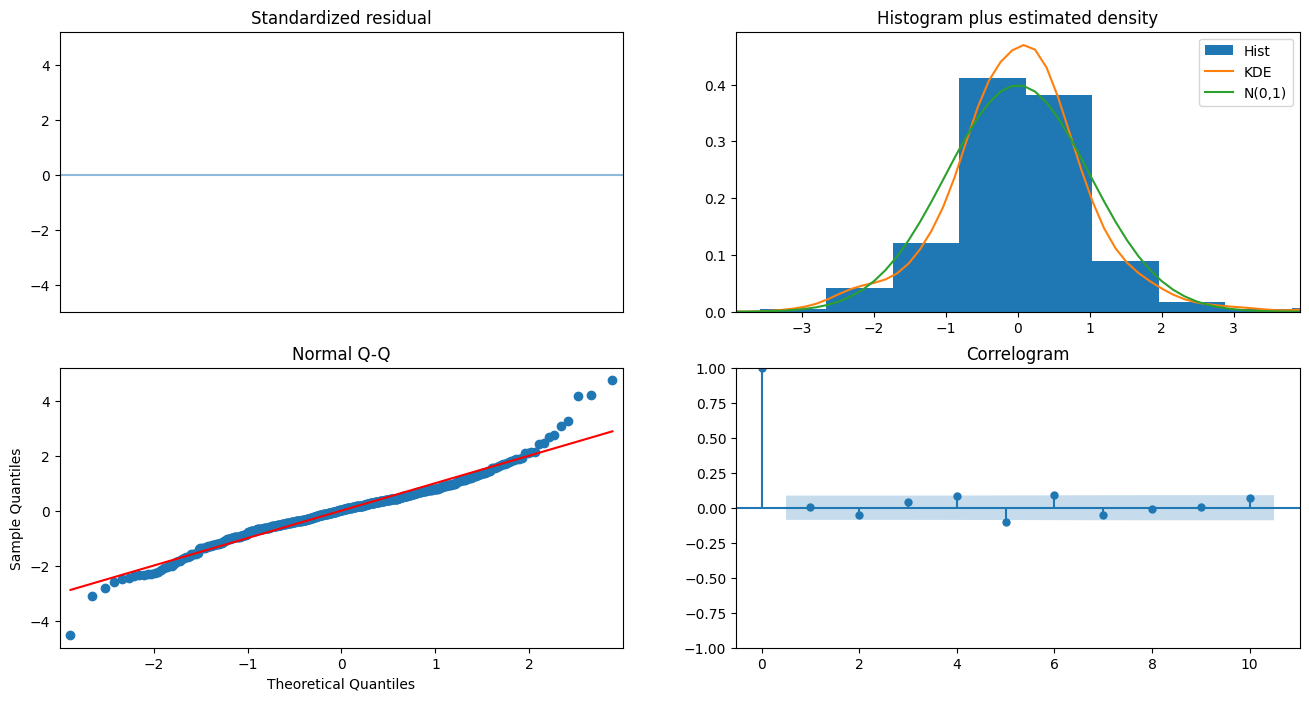

In [223]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

# LSTM

In [203]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [204]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [205]:

from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 9s 8ms/step - loss: 0.0098 - val_loss: 0.0014
Epoch 2/5
406/406 [==============================] - 3s 7ms/step - loss: 0.0030 - val_loss: 7.8548e-04
Epoch 3/5
406/406 [==============================] - 3s 8ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/5
406/406 [==============================] - 3s 9ms/step - loss: 0.0029 - val_loss: 8.4934e-04
Epoch 5/5
406/406 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 5.7218e-04
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            92672     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
         

In [206]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

3/3 [==============================] - 0s 5ms/step
RMSE: 0.34616014744071294


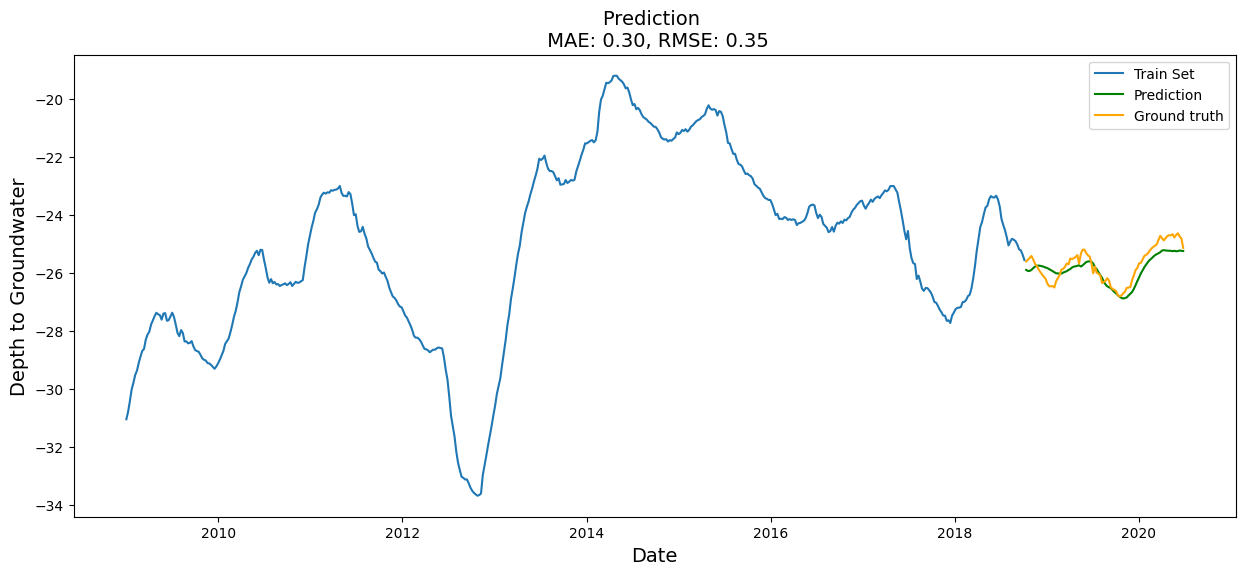

In [207]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

#   Models for Multivariate Time Series

In [208]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

ds          y  rainfall  temperature  \
1970-01-01 00:00:00.000000000 2009-01-01 -31.048571  0.000000     1.657143   
1970-01-01 00:00:00.000000001 2009-01-08 -30.784286  0.285714     4.571429   
1970-01-01 00:00:00.000000002 2009-01-15 -30.420000  0.028571     7.528571   
1970-01-01 00:00:00.000000003 2009-01-22 -30.018571  0.585714     6.214286   
1970-01-01 00:00:00.000000004 2009-01-29 -29.790000  1.414286     5.771429   

                               drainage_volume  river_hydrometry  
1970-01-01 00:00:00.000000000    -28164.918857          2.371429  
1970-01-01 00:00:00.000000001    -29755.789714          2.314286  
1970-01-01 00:00:00.000000002    -25463.190857          2.300000  
1970-01-01 00:00:00.000000003    -23854.422857          2.500000  
1970-01-01 00:00:00.000000004    -25210.532571          2.500000

CONCLUSION

# Multivariate Prophe

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)


In [188]:
from fbprophet import Prophet


# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

ModuleNotFoundError: ignored

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

CONCLUSION:
# The best results are taken from Univariate LSTM (with rolling window of 1 year)